# Importing Libraries


In [1]:
from wfield import *
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import h5py
from scipy.ndimage import label



# Defining functions

In [2]:
def list_scans(data_folder, keyword):
    # Find folders containing the keyword
    scan_folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

    # Print list of found folders
    print(f"Folders containing '{keyword}' keyword:")
    for i, folder in enumerate(scan_folders):
        print(f"{i + 1}. {folder}")

    # Prompt user to choose a folder
    while True:
        choice = input("Enter the number of the scan you want to choose: ")
        if choice.isdigit() and 1 <= int(choice) <= len(scan_folders):
            chosen_folder = scan_folders[int(choice) - 1]
            break
        else:
            print("Invalid input. Please enter a valid number.")
    print("Selected",chosen_folder)
    # Return the path to the chosen folder
    return os.path.join(data_folder, chosen_folder), chosen_folder


In [3]:
def list_bpod(localdisk):
    import scipy.io
    mat_files = glob(pjoin(localdisk,'*.mat'))
    if len(mat_files) > 1:
        print("Multiple Bpod files found:")
        for i, mat_file in enumerate(mat_files):
            print(f"{i + 1}. {os.path.basename(mat_file)}")
        
        while True:
            choice = input("Enter the number of the .dat file you want to choose: ")
            if choice.isdigit() and 1 <= int(choice) <= len(mat_files):
                mat_path = mat_files[int(choice) - 1]
                break
            else:
                print("Invalid input. Please enter a valid number.")
    elif len(mat_files) == 1:
        mat_path = mat_files[0]
        print("Bpod file found")
        print("Loading...")
    else:
        print("Bpod file not found")
        print("-----------------------")
    
    try:
        bpod_data = scipy.io.loadmat(mat_path)
        print("Selected", os.path.basename(mat_path))
    except:
        print("Failed")
    return bpod_data


# Reading Aux file

In [144]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA")

Folders containing 'AA' keyword:
1. Habituation_AA_WEZ-8950_2024-04-16_scan9FNN1Y64_sess9FNN0LFP
2. Habituation_AA_WEZ-8948_2024-04-17_scan9FNNP1N7_sess9FNNO3Z1
3. Oddball_AA_ROS-1706_2024-03-12_scan9FN2BCOS_sess9FN2ANVG
4. AA_ROS-1688_2024_01_27_scan000WQU9_sess000EAEIO
5. Habituation_AA_WEZ-8950_2024-04-18_scan9FNO8CLT_sess9FNO8CLT
6. Habituation_AA_WEZ-8950_2024-04-17_scan9FNNO3Z1_sess9FNNO3Z1
7. AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG
8. Habituation_AA_WEZ-8950_2024-04-16_scan9FNN1YXK_sess9FNN1YXK
9. Habituation_AA_ROS-1783_2024-05-31_scan9FODV06V_sess9FODV06V
10. Habituation_AA_WEZ-8948_2024-04-18_scan9FNO99ZE_sess9FNO8CLT
11. Habituation_AA_ROS-1783_2024-05-27_scan9FOBHGME_sess9FOBHGME
12. Habituation_AA_ROS-1783_2024-05-29_scan9FOCOYKP_sess9FOCOYKP
13. Habituation_AA_ROS-1792_2024-05-29_scan9FOCO8OP_sess9FOCO8OP
14. AA_ROS-1688_2024_01_27_scan000EAEIO_sess000EAEIO
15. Habituation_AA_ROS-1792_2024-05-31_scan9FODTU50_sess9FODTU50
16. Habituation_AA_WEZ-8950_2024-04-16_sca

In [145]:
h5_path = glob(pjoin(localdisk,'*.h5'))[0]
h5_path

'/datajoint-data/data/aeltona/Habituation_AA_ROS-1792_2024-05-31_scan9FODTU50_sess9FODTU50/scan9FODTU50_Habituation_Habituation_AA_ROS-1792_0001.h5'

In [146]:

# Open the HDF5 file
with h5py.File(h5_path, 'r') as f:
    sweep_data_key = list(f.keys())[1]
    sweep_data = f[sweep_data_key]
    header = f['header'] 
    AIChannelNames = header['AIChannelNames'][:]
    YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
    AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
    SampleRate = header['AcquisitionSampleRate'][:]
    analogData = sweep_data['analogScans'][:]

In [147]:
# Convert analogData to DataFrame
df = pd.DataFrame(analogData.T, columns=AIChannelNames)
sampling_rate_hz = SampleRate[0,0]
df['time_seconds'] = df.index / sampling_rate_hz
# Print DataFrame
# print(df)
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HIFI', 'Rew_StimON',
       'TrialON_FRew', 'Lick Count', 'Rotary Encoder', 'time_seconds'],
      dtype='object')

In [148]:
norm_TrialON_FRew = (df['TrialON_FRew'] - df['TrialON_FRew'].min()) / (df['TrialON_FRew'].max() - df['TrialON_FRew'].min())
norm_TrialON_FRew = norm_TrialON_FRew.round(0)

norm_Rew_StimON = (df['Rew_StimON'] - df['Rew_StimON'].min()) / (df['Rew_StimON'].max() - df['Rew_StimON'].min())
norm_Rew_StimON = norm_Rew_StimON.round(0)

norm_licks = (df['Lick Count'] - df['Lick Count'].min()) / (df['Lick Count'].max() - df['Lick Count'].min())
norm_licks = norm_licks.round(0)

In [149]:
def find_event_sizes(signal):
    event_sizes = []
    event_positions = []
    trialON_idx = []
    rewards_idx = []
    event_start = None

    for i, val in enumerate(signal):
        if val == 1 and event_start is None:
            event_start = i
        elif val == 0 and event_start is not None:
            event_duration = i - event_start
            event_sizes.append(event_duration)
            if event_duration > 10:
                rewards_idx.append((event_start, i))
            else:
                trialON_idx.append((event_start, i))
            # event_positions.append((event_start, i))
            event_start = None

    if event_start is not None:  # Handle case where the last event goes till the end
        event_duration = len(signal) - event_start
        event_sizes.append(event_duration)
        event_positions.append((event_start, len(signal)))
    
    return event_sizes, trialON_idx,rewards_idx

In [150]:
event_sizes, trialON_idx, rews_idx  = find_event_sizes(norm_Rew_StimON)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of rews_idx:", len(rews_idx))

Event sizes: [5250]
Length of trialON_idx: 0
Length of rews_idx: 25


In [151]:
event_sizes, trialON_idx, frews_idx  = find_event_sizes(norm_TrialON_FRew)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of frews_idx:", len(frews_idx))

Event sizes: [   1    2 5250 5251]
Length of trialON_idx: 121
Length of frews_idx: 96


In [152]:
# Create arrays for trial onsets and rewards
trial_onsets = np.zeros_like(norm_TrialON_FRew)
frews = np.zeros_like(norm_TrialON_FRew)
rews = np.zeros_like(norm_Rew_StimON)

for start, end in trialON_idx:
    trial_onsets[start:end] = 1

for start, end in frews_idx:
    frews[start:end] = 1

for start, end in rews_idx:
    rews[start:end] = 1

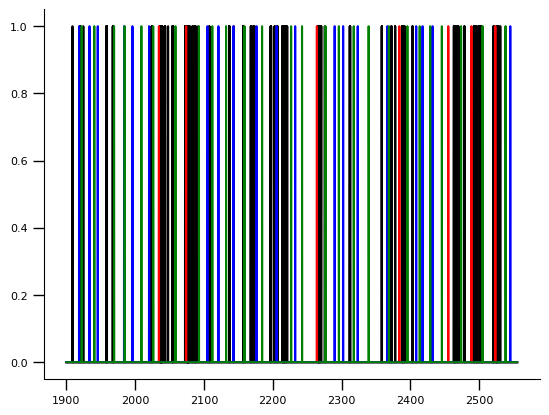

In [153]:
start = int(1900*sampling_rate_hz)
end = int(2555*sampling_rate_hz)

plt.plot(df['time_seconds'][start:end],norm_licks[start:end],c = 'black'); #[start:end]
plt.plot(df['time_seconds'][start:end],rews[start:end], c='red');
plt.plot(df['time_seconds'][start:end],frews[start:end], c='blue');
plt.plot(df['time_seconds'][start:end],trial_onsets[start:end], c='green');
# plt.legend(loc='upper right')


In [154]:
def extract_trials(data, idx_list, pre_window, post_window):
    trials = []
    for start, end in idx_list:
        trial_start = max(0, start - pre_window)
        trial_end = min(len(data), end + post_window)
        trial_data = data[trial_start:trial_end]
        trials.append(trial_data)
    return trials

In [155]:
pre_window = int(5 * sampling_rate_hz)  # 5 seconds before
post_window = int(10 * sampling_rate_hz)  # 10 seconds after

frews_trials = extract_trials(norm_licks, frews_idx, pre_window, post_window)
rews_trials = extract_trials(norm_licks, rews_idx, pre_window, post_window)


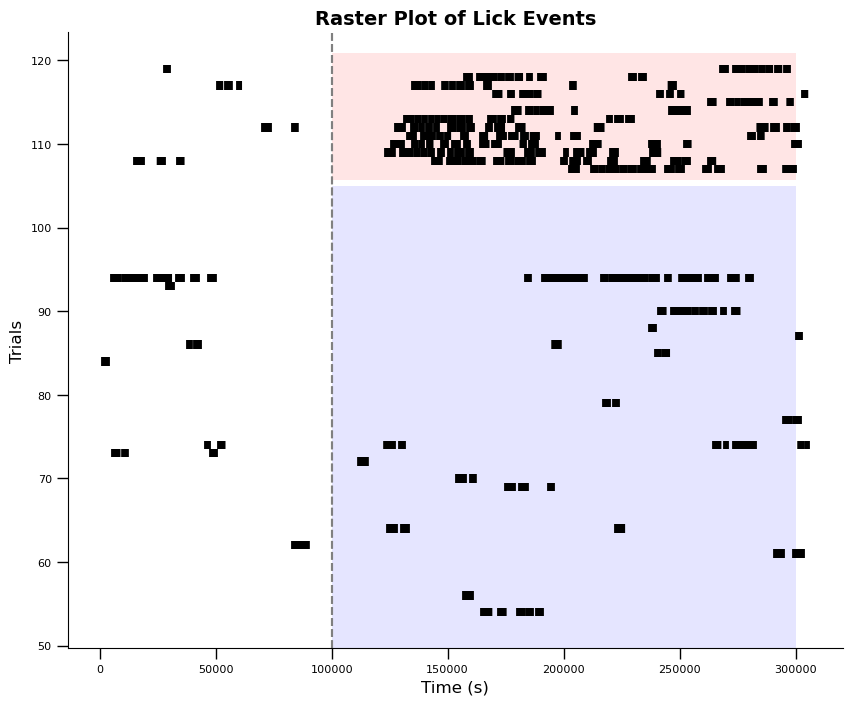

In [156]:


# Plotting
plt.figure(figsize=(10, 8))

# Plot frews trials
for i, trial in enumerate(frews_trials):
    plt.eventplot(np.where(trial)[0], lineoffsets=i, colors='black')

# Plot rews trials
offset = len(frews_trials)
for i, trial in enumerate(rews_trials):
    plt.eventplot(np.where(trial)[0], lineoffsets=i + offset, colors='black')

# Add shading for different time windows
# Plot boundaries
for i in range(len(frews_trials)):
    i-= (len(rews_trials)-1)
    plt.axvspan(pre_window, pre_window + post_window, facecolor='blue', alpha=0.1, ymin=i/len(frews_trials), ymax=(i+1)/len(frews_trials))

for i in range(len(rews_trials)):
    i-=4
    plt.axvspan(pre_window, pre_window + post_window, facecolor='red', alpha=0.1, ymin=(i+offset)/len(frews_trials + rews_trials), ymax=((i+1)+offset)/len(frews_trials + rews_trials))

# Formatting
plt.xlabel('Time (s)')
plt.ylabel('Trials')
plt.title('Raster Plot of Lick Events')
# plt.xlim([-pre_window, post_window])
plt.axvline(pre_window, color='grey', linestyle='--')  # Indicate the stimulus onset
plt.axvline(pre_window + (post_window - 10 * sampling_rate_hz), color='grey', linestyle='--')  # Indicate 10s after offset


# plt.xticks(ticks=np.arange(-5, 11, 1), labels=np.arange(-5, 11, 1))

# Show plot
plt.show()

In [37]:
df['trial_onsets'] = trial_onsets
df['norm_licks'] = norm_licks
df['rews'] = rews
df['frews'] = frews
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HIFI', 'Rew_StimON',
       'TrialON_FRew', 'Lick Count', 'Rotary Encoder', 'time_seconds',
       'trial_onsets', 'norm_licks', 'rews', 'frews'],
      dtype='object')

# Reading Bpod Data


In [ ]:
bpod_data = list_bpod(localdisk)

Bpod file found
Loading...
Selected scan9FN2ANVG_Oddball_AA_ROS-1706_2024_03_12_bpod.mat
